In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv']


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("../input/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.dropna()
df_idx = df.set_index(["Timestamp"], drop=True)
df.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2099755,2019-01-07 22:02:00,4006.01,4006.57,4006.00,4006.01,3.382954,13553.433078,4006.390309
2099756,2019-01-07 22:03:00,4006.01,4006.57,4006.00,4006.01,0.902164,3614.083169,4006.017233
2099757,2019-01-07 22:04:00,4006.01,4006.01,4006.00,4006.01,1.192123,4775.647308,4006.003635
2099758,2019-01-07 22:05:00,4006.01,4006.01,4005.50,4005.50,2.699700,10814.241898,4005.719991
2099759,2019-01-07 22:06:00,4005.51,4006.01,4005.51,4005.99,1.752778,7021.183546,4005.745614


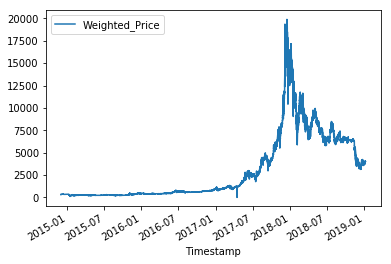

In [5]:
# flip the dataframe
df_idx = df_idx.sort_index(axis=1, ascending=True)
# df_idx = df_idx.iloc[::-1]
# plot the data
data = df_idx[['Weighted_Price']]
data.plot(y='Weighted_Price')

In [ ]:
print(data.index.values[0])
print(data.index.values[-1])


In [6]:
diff = data.index.values[-1] - data.index.values[0]
print(diff)
days = diff.astype('timedelta64[D]')
print(days)
days = days / np.timedelta64(1, 'D')
print(days)
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2014 to %d"%(2014 + int(0.8*years)))

129486780000000000 nanoseconds
1498 days
1498.0
Total data: 4 years
80 percent data = 2014 to 2017


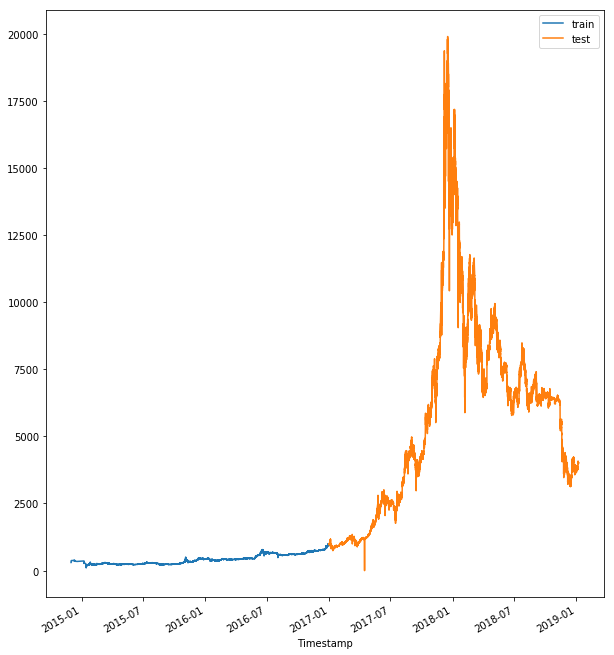

In [7]:
# create training and testing data
split_date = pd.Timestamp('01-01-2017')
train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10, 12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

**Data normalization**

*Why data normalization here and what method is normaly used for data normalization*

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [18]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1, 2):
    train_sc_df['X_{}'.format(s)]=train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)]=test_sc_df['Y'].shift(s)
    
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)



X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (942129 x 1)
Test size: (1048561 x 1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


**Setup baseline model of SVM Regressor**

*what is SVM regressor and why regressor here?*

In [20]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


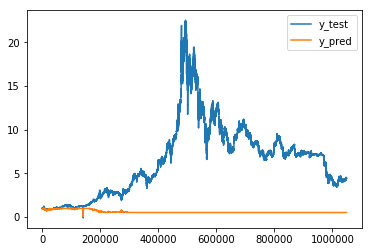

In [23]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['y_test', 'y_pred'])
plt.show()

*why r2_score here and why adj_r2_score function here*

In [24]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

r2_test = r2_score(y_test, y_pred)
print('R-squared is : %f'%r2_test)

R-squared is : -1.966786


 **Build a neural network**

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

*What is Seqential model, Dense, kernel_initializer, optimizers(Adam) and fit verbose*

**1 hidden layer with 1 newron**

In [32]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
942129/942129 [==============================] - 42s 44us/step - loss: 9.3778e-04
Epoch 2/20
942129/942129 [==============================] - 44s 47us/step - loss: 5.1421e-04
Epoch 3/20
942129/942129 [==============================] - 41s 44us/step - loss: 5.1423e-04
Epoch 4/20
942129/942129 [==============================] - 41s 43us/step - loss: 5.1425e-04
Epoch 5/20
942129/942129 [==============================] - 41s 44us/step - loss: 5.1416e-04
Epoch 6/20
942129/942129 [==============================] - 43s 45us/step - loss: 5.1422e-04
Epoch 7/20
942129/942129 [==============================] - 43s 46us/step - loss: 5.1413e-04
Epoch 8/20
942129/942129 [==============================] - 42s 44us/step - loss: 5.1412e-04
Epoch 9/20
942129/942129 [==============================] - 44s 47us/step - loss: 5.1414e-04
Epoch 10/20
942129/942129 [==============================] - 43s 46us/step - loss: 5.1416e-04
Epoch 11/20
942129/94

R-Squared: -1.652139


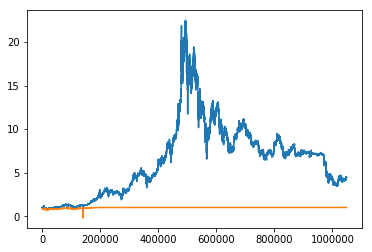

In [33]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

**2 Hidden layers with 50 neurons each and ReLu activation function**

*why three Dense function?*

In [35]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
942129/942129 [==============================] - 55s 59us/step - loss: 1.0046e-05
Epoch 2/20
942129/942129 [==============================] - 56s 59us/step - loss: 1.3383e-06
Epoch 3/20
942129/942129 [==============================] - 62s 66us/step - loss: 1.1636e-06
Epoch 4/20
942129/942129 [==============================] - 62s 66us/step - loss: 1.0541e-06
Epoch 5/20
942129/942129 [==============================] - 61s 65us/step - loss: 1.0291e-06
Epoch 6/20
942129/942129 [==============================] - 62s 66us/step - loss: 1.0106e-06
Epoch 7/20
942129/942129 [==============================] - 61s 65us/step - loss: 1.0021e-06
Epoch 8/20
942129/942129 [==============================] - 62s 65us/step - loss: 9.8371e-07
Epoch 9/20
942129/942129 [==============================] - 63s 66us/step - loss: 9.8194e-07
Epoch 10/20
942129/942129 [==============================] - 62s 66us/step - loss: 9.6243e-07
Epoch 11/20
942129/942129 [==============================] - 61s 65us

R-Squared: 0.989937


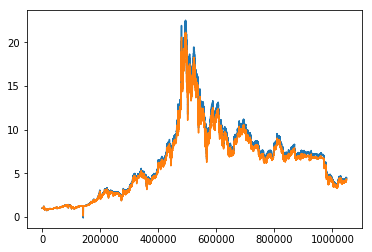

In [36]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))